In [1]:
"""Import libraries"""
from typing import Optional, Union, Tuple, List, Callable, Dict
import torch
from diffusers import StableDiffusionPipeline
import torch.nn.functional as nnf
import numpy as np
import abc
import ptp_utils
import pandas as pd
import ast
import os
import csv

In [2]:
# Access information
description_file_path = os.path.join(os.path.dirname(os.getcwd()), "descriptions/340_final_text_list.csv") # csv path of concept-word sets
LOW_RESOURCE = False
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
gpu_num = 0
device = torch.device(f"cuda:{gpu_num}") if torch.cuda.is_available() else torch.device("cpu")
ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
model_version = "sd_v1_4"
tokenizer = ldm_stable.tokenizer

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
"""Define functions"""
# --- define CONCEPTS --- #
data = []
with open(description_file_path, "r") as f:
    render = csv.reader(f)
    for row in render:
        data.append(row)
num_list = np.arange(1, 11).astype(str)
data = [row for row in data if row != []]
data = [row[0] for row in data if not any(num in row[0] for num in num_list)]
data[0] = data[0].replace("\ufeff","")

CONCEPTS = data
# --------------------------- #

def extract_head_list(concept=None, file_path=None, complement=False):
    """Extract heads from the given concept in the given files"""
    if concept not in CONCEPTS:
        raise ValueError(f"Invalid visual concept: {concept}")
    
    related_heads = []
    df = pd.read_csv(file_path)
    concepts = df[df.columns[0]].values
    positions = df[df.columns[1]].values

    for concept_idx, concept_name in enumerate(concepts):
        if concept == concept_name:
            related_heads += ast.literal_eval(positions[concept_idx].replace("' '", "', '").replace("\n", ","))

    for idx, related_head in enumerate(related_heads):
        a, b, c = related_head.split(",")
        related_heads[idx] = (a, int(b.replace("layer: ","")), int(c.replace("head: ","")))

    if complement:
        if model_version == "sd_v1_4":
            full_heads = []
            for key in ["down", "mid", "up"]:
                if key == "down":
                    for l in range(6):
                        for h in range(8):
                            full_heads.append((key, l, h))
                elif key == "mid":
                    for l in range(1):
                        for h in range(8):
                            full_heads.append((key, l, h))
                else:
                    for l in range(9):
                        for h in range(8):
                            full_heads.append((key, l, h))
            final_heads = [head for head in full_heads if head not in related_heads]
        else:
            raise Exception("Not implemented yet")
    else:
        final_heads = related_heads
    
    return final_heads

def get_replacement_mapper_(x: str, y: str, tokenizer, max_len=77):
    words_x = x.split(' ')
    words_y = y.split(' ')
    if len(words_x) != len(words_y):
        raise ValueError(f"attention replacement edit can only be applied on prompts with the same length"
                         f" but prompt A has {len(words_x)} words and prompt B has {len(words_y)} words.")
    inds_replace = [i for i in range(len(words_y)) if words_y[i] != words_x[i]]
    inds_source = [get_word_inds(x, i, tokenizer) for i in inds_replace]
    inds_target = [get_word_inds(y, i, tokenizer) for i in inds_replace]
    mapper = np.zeros((max_len, max_len))
    i = j = 0
    cur_inds = 0
    while i < max_len and j < max_len:
        if cur_inds < len(inds_source) and inds_source[cur_inds][0] == i:
            inds_source_, inds_target_ = inds_source[cur_inds], inds_target[cur_inds]
            if len(inds_source_) == len(inds_target_):
                mapper[inds_source_, inds_target_] = 1
            else:
                ratio = 1 / len(inds_target_)
                for i_t in inds_target_:
                    mapper[inds_source_, i_t] = ratio
            cur_inds += 1
            i += len(inds_source_)
            j += len(inds_target_)
        elif cur_inds < len(inds_source):
            mapper[i, j] = 1
            i += 1
            j += 1
        else:
            mapper[j, j] = 1
            i += 1
            j += 1

    return torch.from_numpy(mapper).float()

def get_replacement_mapper(prompts, tokenizer, max_len=77):
    x_seq = prompts[0]
    mappers = []
    for i in range(1, len(prompts)):
        mapper = get_replacement_mapper_(x_seq, prompts[i], tokenizer, max_len)
        mappers.append(mapper)
    return torch.stack(mappers)


def update_alpha_time_word(alpha, bounds: Union[float, Tuple[float, float]], prompt_ind: int, 
                           word_inds: Optional[torch.Tensor]=None):
    if type(bounds) is float:
        bounds = 0, bounds
    start, end = int(bounds[0] * alpha.shape[0]), int(bounds[1] * alpha.shape[0])
    if word_inds is None:
        word_inds = torch.arange(alpha.shape[2])
    alpha[:start, prompt_ind, word_inds] = 0
    alpha[start: end, prompt_ind, word_inds] = 1
    alpha[end:, prompt_ind, word_inds] = 0
    return alpha

def get_time_words_attention_alpha(prompts, num_steps,
                                   cross_replace_steps: Union[float, Dict[str, Tuple[float, float]]],
                                   tokenizer, max_num_words=77):
    if type(cross_replace_steps) is not dict:
        cross_replace_steps = {"default_": cross_replace_steps}
    if "default_" not in cross_replace_steps:
        cross_replace_steps["default_"] = (0., 1.)
    # for model v1.4, change [num_steps -> num_steps + 1]
    if model_version == "sd_v1_4":
        alpha_time_words = torch.zeros(num_steps+1, len(prompts) - 1, max_num_words)
    else:
        alpha_time_words = torch.zeros(num_steps, len(prompts) - 1, max_num_words)
    for i in range(len(prompts) - 1):
        alpha_time_words = update_alpha_time_word(alpha_time_words, cross_replace_steps["default_"], i)
    
    for key, item in cross_replace_steps.items():
        if key != "default_":
            inds = [get_word_inds(prompts[i], key, tokenizer) for i in range(1, len(prompts))]
            for i, ind in enumerate(inds):
                if len(ind) > 0:
                    alpha_time_words = update_alpha_time_word(alpha_time_words, item, i, ind)
    # for model v1.4, change [num_steps -> num_steps + 1]
    if model_version == "sd_v1_4":
        alpha_time_words = alpha_time_words.reshape(num_steps+1, len(prompts) - 1, 1, 1, max_num_words)
    else:
        alpha_time_words = alpha_time_words.reshape(num_steps, len(prompts) - 1, 1, 1, max_num_words)
    return alpha_time_words

def get_word_inds(text: str, word_place, tokenizer):
    """Return the index of 'word_place' in the tokenzied 'text'
       cf) 'word_place' may appear multiple times in the 'text'"""
    split_text = text.split(" ")
    if type(word_place) is str:
        word_place = word_place.strip()
        if len(word_place.split(" ")) == 1:
            word_place = [i for i, word in enumerate(split_text) if word_place == word]
        else:
            word_place_splited = word_place.split(" ")
            word_place_ = []
            for i, word in enumerate(split_text):
                if word == word_place_splited[0]:
                    if split_text[i:i+len(word_place_splited)] == word_place_splited:
                        word_place_ += [j for j in range(i, i+len(word_place_splited))]
            word_place = word_place_
    elif type(word_place) is int:
        word_place = [word_place]
    out = []
    if len(word_place) > 0:
        words_encode = [tokenizer.decode([item]).strip("#") for item in tokenizer.encode(text)][1:-1]
        cur_len, ptr = 0, 0
        for i in range(len(words_encode)):
            cur_len += len(words_encode[i])
            if ptr in word_place:
                out.append(i + 1)
            if cur_len >= len(split_text[ptr]):
                ptr += 1
                cur_len = 0
    return np.array(out)

def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    """"Equalizer for attention reweighting"""
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select, )
    equalizer = torch.ones(len(values), 77)
    values = torch.tensor(values, dtype=torch.float32)
    for word in word_select:
        inds = get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = values
    return equalizer

def diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False):
    if low_resource:
        noise_pred_uncond = model.unet(latents, t, encoder_hidden_states=context[0])["sample"]
        noise_prediction_text = model.unet(latents, t, encoder_hidden_states=context[1])["sample"]
    else:
        latents_input = torch.cat([latents] * 2)
        noise_pred = model.unet(latents_input, t, encoder_hidden_states=context)["sample"] # Focus here!
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
    latents = model.scheduler.step(noise_pred, t, latents)["prev_sample"]
    latents = controller.step_callback(latents)
    return latents


def latent2image(vae, latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents)['sample']
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).astype(np.uint8)
    return image


def init_latent(latent, model, height, width, generator, batch_size):
    if latent is None:
        latent = torch.randn(
            (1, model.unet.config.in_channels, height // 8, width // 8),
            generator=generator
        )
    latents = latent.expand(batch_size, model.unet.config.in_channels, height // 8, width // 8).to(model.device)
    return latent, latents

@torch.no_grad()
def text2image_ldm_stable(
    model,
    prompt: List[str],
    controller,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    generator: Optional[torch.Generator] = None,
    latent: Optional[torch.FloatTensor] = None,
    low_resource: bool = False,
    negative_prompt: bool = False,
): 
    
    register_attention_control(model, controller) # modifies a forward pass of the model
    height = width = 512
    batch_size = len(prompt)

    text_input = model.tokenizer(
        prompt,
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0]
    max_length = text_input.input_ids.shape[-1]
    if negative_prompt:
        uncond_input = model.tokenizer(
            ["ugly, bad anatomy, bad quality, blurry, disconnected limbs, disfigured, disgusting, fused fingers, long neck, low quality, jpeg artifacts, mutated limbs, mutated fingers, poorly drawn face, watermark, username, error, worst quality, pixel, low resolution, disgusting"] * batch_size, 
            padding="max_length", max_length=max_length, return_tensors="pt"
        )
    else:
        uncond_input = model.tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
    uncond_embeddings = model.text_encoder(uncond_input.input_ids.to(model.device))[0]

    context = [uncond_embeddings, text_embeddings]
    if not low_resource:
        context = torch.cat(context)
    latent, latents = init_latent(latent, model, height, width, generator, batch_size)

    model.scheduler.set_timesteps(num_inference_steps)
    for t in model.scheduler.timesteps:
        latents = diffusion_step(model, controller, latents, context, t , guidance_scale, low_resource)

    image = latent2image(model.vae, latents)

    return image, latent


def register_attention_control(model, controller): 
    def ca_forward(self, place_in_unet, count):
        to_out = self.to_out
        if type(to_out) is torch.nn.modules.container.ModuleList:
            to_out = to_out[0]
        else:
            to_out = self.to_out
        
        def forward(hidden_states, encoder_hidden_states=None, attention_mask=None, temb=None,):
            is_cross = encoder_hidden_states is not None
            layer = count // 2 # layer index

            residual = hidden_states

            if self.spatial_norm is not None:
                hidden_states = self.spatial_norm(hidden_states, temb)
            
            input_ndim = hidden_states.ndim

            if input_ndim == 4:
                batch_size, channel, height, width = hidden_states.shape
                hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)
            
            batch_size, sequence_length, _ = (
                hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
            )
            attention_mask = self.prepare_attention_mask(attention_mask, sequence_length, batch_size)

            if self.group_norm is not None:
                hidden_states = self.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)
            
            query = self.to_q(hidden_states)

            if encoder_hidden_states is None:
                encoder_hidden_states = hidden_states
            elif self.norm_cross:
                encoder_hidden_states = self.norm_encoder_hidden_states(encoder_hidden_states)

            key = self.to_k(encoder_hidden_states) # (only for is_cross=True) encoder_hidden_states.shape = (2*batch_size, 77, 768) ex. self: encoder_hidden_states.shape = (2*batch_size, 4096, 320) 
            value = self.to_v(encoder_hidden_states)
            wo_head = key.shape[0] # 2*batch_size

            query = self.head_to_batch_dim(query)
            key = self.head_to_batch_dim(key) # (only for is_cross=True) (2*batch_size*h, 77, 40)
            value = self.head_to_batch_dim(value)
            w_head = key.shape[0] # 2*batch_size*h
            num_head = int(w_head // wo_head)

            attention_probs = self.get_attention_scores(query, key, attention_mask) # shape: [2*batch*h, res*res, 77]
            attention_probs = controller(attention_probs, is_cross, place_in_unet, layer)  # Focus here!
            # --------------------------------------------------- #
            # controller(result, is_cross, place_in_unet)
            # --------------------------------------------------- #

            hidden_states = torch.bmm(attention_probs, value)
            hidden_states = self.batch_to_head_dim(hidden_states)

            # linear proj
            hidden_states = to_out(hidden_states)

            if input_ndim == 4:
                hidden_states = hidden_states.transpose(1, 2).view(batch_size, channel, height, width)

            if self.residual_connection:
                hidden_states = hidden_states + residual
            
            hidden_states = hidden_states / self.rescale_output_factor

            return hidden_states
        return forward
    
    class DummyController:

        def __call__(self, *args):
            return args[0]
        
        def __init__(self):
            self.num_att_layers = 0
    
    if controller is None:
        controller = DummyController()
    
    def register_recr(net_, count, place_in_unet):
        if net_.__class__.__name__ == "Attention":
            net_.forward = ca_forward(net_, place_in_unet, count)
            return count + 1
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                count = register_recr(net__, count, place_in_unet)
        return count

    att_count = 0
    sub_nets = model.unet.named_children()
    for net in sub_nets:
        if "down" in net[0]:
            att_count += register_recr(net[1], 0, "down")
        elif "up" in net[0]:
            att_count += register_recr(net[1], 0, "up")
        elif "mid" in net[0]:
            att_count += register_recr(net[1], 0 , "mid")
    
    controller.num_att_layers = att_count

### Original P2P

In [4]:
"""Define Attention controls for reweighting all cross attention layers (from prompt-to-prompt)"""
class LocalBlend: # check this later
    def __call__(self, x_t, attention_store):
        k = 1
        maps = attention_store["down_cross"][2:4] + attention_store["up_cross"][:3]
        maps = [item.reshape(self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS) for item in maps]
        maps = torch.cat(maps, dim=1)
        maps = (maps * self.alpha_layers).sum(-1).mean(1)
        mask = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 +1), (1, 1), padding=(k, k))
        mask = nnf.interpolate(mask, size=(x_t.shape[2:]))
        mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
        mask = mask.gt(self.threshold)
        mask = (mask[:1] + mask[1:]).float()
        x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t
       
    def __init__(self, prompts: List[str], words: [List[List[str]]], threshold=.3):
        alpha_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1
        self.alpha_layers = alpha_layers.to(device)
        self.threshold = threshold

class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward(self, attn, is_cross: bool, place_in_unet: str, layer):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str, layer):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet, layer)
            else:
                h = attn.shape[0] 
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet, layer) # Save attention map with text conditions
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0
    
    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):

    def forward(self, attn, is_cross: bool, place_in_unet: str, layer):
        return attn

class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}
    
    def forward(self, attn ,is_cross: bool, place_in_unet: str, layer):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        # deactivate storing attention maps
        # if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            # self.step_store[key].append(attn)
        return attn
    
    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()
    
    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention
    
    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}
    
    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

class AttentionControlEdit(AttentionStore, abc.ABC):
    
    def step_callback(self, x_t):
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store)
        return x_t
        
    def replace_self_attention(self, attn_base, att_replace):
        if att_replace.shape[2] <= 16 ** 2:
            return attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
        else:
            return att_replace
    
    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError
    
    def forward(self, attn, is_cross: bool, place_in_unet: str, layer):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet, layer)
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_replace = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_replace_new = self.replace_cross_attention(attn_base, attn_replace) * alpha_words + (1 - alpha_words) * attn_replace
                attn[1:] = attn_replace_new
            else:
                attn[1:] = self.replace_self_attention(attn_base, attn_replace)
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn
    
    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).to(device)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend

class AttentionReplace(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)
      
    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper = get_replacement_mapper(prompts, tokenizer).to(device)

"""run and display code"""
def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, low_resource=LOW_RESOURCE) # I added desc_embeddings, len_tokens
    ptp_utils.view_images(images)
    return images, x_t

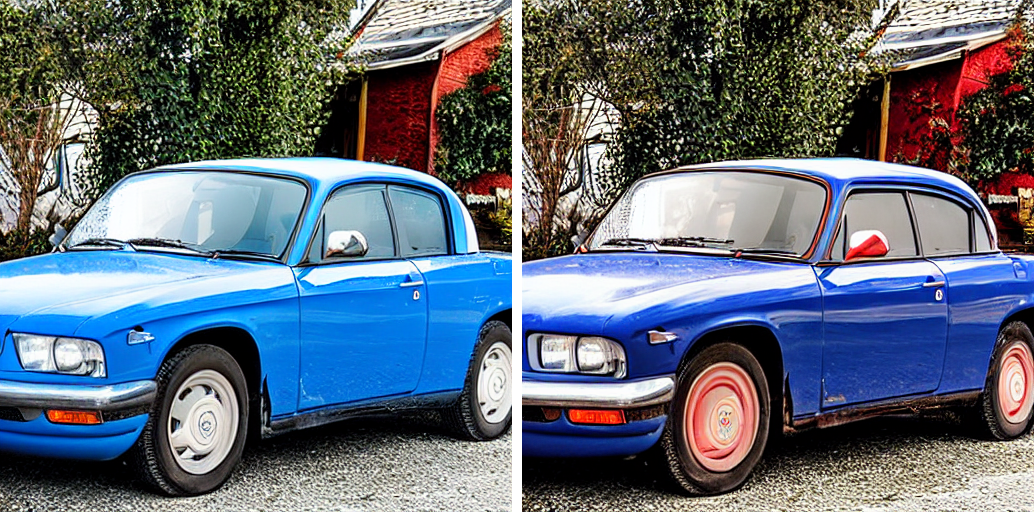

In [5]:
"""Original P2P
Left: source image \\ Right: target image generated by P2P"""
prompts = ["a blue car",
           "a red car"] # prompts = [source_prompt, target_prompt]

for i in [20]: 
    g_cpu = torch.Generator().manual_seed(i)
    controller = AttentionReplace(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=0.8, self_replace_steps=0.4)
    _ = run_and_display(prompts, controller, run_baseline=False, generator=g_cpu) 

### P2P-HRV

In [6]:
class LocalBlend: # check this later
    def __call__(self, x_t, attention_store):
        k = 1
        maps = attention_store["down_cross"][2:4] + attention_store["up_cross"][:3]
        maps = [item.reshape(self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS) for item in maps]
        maps = torch.cat(maps, dim=1)
        maps = (maps * self.alpha_layers).sum(-1).mean(1)
        mask = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 +1), (1, 1), padding=(k, k))
        mask = nnf.interpolate(mask, size=(x_t.shape[2:]))
        mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
        mask = mask.gt(self.threshold)
        mask = (mask[:1] + mask[1:]).float()
        x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t
       
    def __init__(self, prompts: List[str], words: [List[List[str]]], threshold=.3):
        alpha_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1
        self.alpha_layers = alpha_layers.to(device)
        self.threshold = threshold

class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward(self, attn, is_cross: bool, place_in_unet: str, layer):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str, layer):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet, layer)
            else:
                h = attn.shape[0] 
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet, layer) # Save attention map with text conditions
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0
    
    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):

    def forward(self, attn, is_cross: bool, place_in_unet: str, layer):
        return attn

class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}
    
    def forward(self, attn ,is_cross: bool, place_in_unet: str, layer):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        # deactivate storing attention maps
        # if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            # self.step_store[key].append(attn)
        return attn
    
    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()
    
    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention
    
    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}
    
    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

class AttentionControlEdit(AttentionStore, abc.ABC):
    
    def step_callback(self, x_t):
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store)
        return x_t
        
    def replace_self_attention(self, attn_base, att_replace):
        if att_replace.shape[2] <= 16 ** 2:
            return attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
        else:
            return att_replace
    
    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError

    def forward(self, attn, is_cross: bool, place_in_unet: str, layer):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet, layer)
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            if is_cross:
                num_head = attn.shape[0] // (self.batch_size) # attn.shape: (batch_size * num_head, res^2, 77)
                attn = attn.reshape(self.batch_size, num_head, *attn.shape[1:])
                attn_base, attn_replace = attn[0], attn[1:]
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_source = self.replace_cross_attention(attn_base, attn_replace) # (batch_size - 1, num_head, res^2, 77)
                if self.replace_all_heads or self.use_soft_vector:
                    if self.cur_step >= self.token_insertion_step:
                        for concept_idx, _ in enumerate(self.concepts):
                            for head in range(num_head):
                                attn_source[:, head, :, :] = self.replace_token_maps(attn_source[:, head, :, :], attn_replace[:, head, :, :], 
                                                                                     concept_idx, place_in_unet, layer, head)
                else:
                    for concept_idx, place, l, head in self.head_list:
                        if self.cur_step >= self.token_insertion_step and place_in_unet == place and layer == l:
                            attn_source[:, head, :, :] = self.replace_token_maps(attn_source[:, head, :, :], attn_replace[:, head, :, :], concept_idx, 
                                                                                 place_in_unet, layer, head)
                attn_replace_new = attn_source * alpha_words + (1 - alpha_words) * attn_replace
                attn[1:] = attn_replace_new
                attn = attn.reshape(self.batch_size * num_head, *attn.shape[2:])
            else:
                num_head = attn.shape[0] // (self.batch_size)
                attn = attn.reshape(self.batch_size, num_head, *attn.shape[1:])
                attn_base, attn_replace = attn[0], attn[1:]
                attn[1:] = self.replace_self_attention(attn_base, attn_replace)
                attn = attn.reshape(self.batch_size * num_head, *attn.shape[2:])
        return attn
    
    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend], use_soft_vector=None):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).to(device)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend
        self.use_soft_vector = use_soft_vector

class AttentionReplace(AttentionControlEdit):

    def replace_token_maps(self, source, target, concept_idx, place_in_unet=None, layer=None, head=None):
        result = torch.zeros_like(source) # (batch_size - 1, res^2, 77)
        for prompt_idx in range(self.batch_size - 1):
            word_indices = self.word_indices[prompt_idx][concept_idx]
            mask = torch.zeros_like(source[prompt_idx]) # (res^2, 77)
            mask[:, word_indices] = 1
            if self.use_soft_vector:
                head_pos = f"{place_in_unet}, layer: {layer}, head: {head}"
                soft_rescale_factor = self.concept_vectors[CONCEPTS.index(self.concepts[0]), np.where(self.head_index == head_pos)[0][0]]
                result[prompt_idx] = (1 - mask) * source[prompt_idx] + mask * target[prompt_idx] * soft_rescale_factor
            else: # deprecated
                result[prompt_idx] = (1 - mask) * source[prompt_idx] + mask * target[prompt_idx]
        return result

    def replace_cross_attention(self, attn_base, attn_replace):
        # (num_head, res&2, 77), (batch_size - 1, 77, 77) -> (batch_size - 1, num_head, res^2, 77)
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper) 

    def categorize_head_list(self, concept_idx, head_list):
        categorized_head_list = [(concept_idx,) + head for head in head_list]
        return categorized_head_list
      
    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None, concepts=None, word_indices=None, file_path=None, 
                 complement=False, token_insertion_step=3, replace_all_heads=False,
                 concept_vectors=None, head_index=None, use_soft_vector=None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend, use_soft_vector)
        self.batch_size = len(prompts)
        self.concepts = concepts
        self.word_indices = word_indices
        self.token_insertion_step = token_insertion_step
        self.replace_all_heads = replace_all_heads
        self.concept_vectors = concept_vectors
        self.head_index = head_index
        self.use_soft_vector = use_soft_vector
        self.mapper = get_replacement_mapper(prompts, tokenizer).to(device)
        self.head_list = []
        if concepts is not None and not self.replace_all_heads and not self.use_soft_vector:
            for concept_idx, concept in enumerate(concepts):
                head_list = extract_head_list(concept, file_path, complement)
                self.head_list += self.categorize_head_list(concept_idx, head_list)
                print(f"concept: {concept}, num_heads: {len(head_list)}")

"""run and display code"""
def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None, verbose=True):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, low_resource=LOW_RESOURCE) 
    if verbose:
        ptp_utils.view_images(images)
    return images, x_t

print(CONCEPTS)

['Animals', 'Plants', 'Fruits and Vegetables', 'People', 'Vehicles', 'Buildings', 'Furniture', 'Electronics', 'Clothing', 'Accessories', 'Tools', 'Toys', 'Food and Beverages', 'Books and Documents', 'Sports Equipment', 'Musical Instruments', 'Written Characters', 'Color', 'Shape', 'Texture', 'Size', 'Counting', 'Image Style', 'Material', 'Lighting Conditions', 'Facial Expressions', 'Facial Features', 'Poses and Gestures', 'Nature Scenes', 'Weather Conditions', 'Time of Day', 'Geo-locations', 'Brand Logos', 'Geometric Patterns']


[[array([2])]]


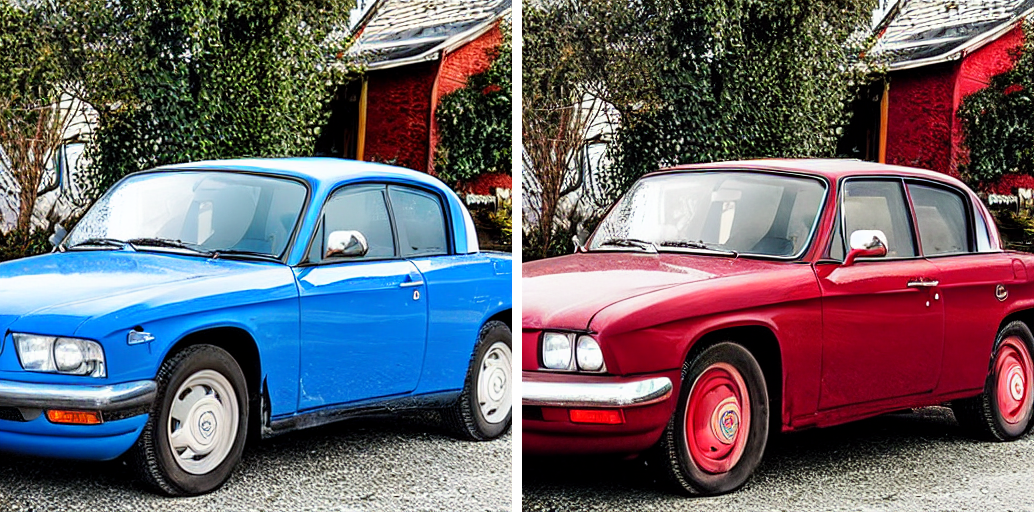

In [7]:
"""P2P-HRV
Left: source image \\ Right: target image generated by P2P-HRV"""
file_path = None # specify top_k csv file path if you want to use only top k relevant heads
complement = False
replace_all_heads = True # If True, all heads are replaced. If False, only top k heads are replaced.
use_soft_vector = True
cross_replace_steps = 0.8
self_replace_steps = 0.9
concept_vectors = np.load(os.path.join(os.path.dirname(os.getcwd()), f"final_result/category_vectors_epoch_1_to_1_neg_prompt_False_merged_340_final_text_descriptions_sd_v1_4.npy"))
head_index = np.load(os.path.join(os.path.dirname(os.getcwd()), f"final_result/head_index_epoch_1_to_1_neg_prompt_False_merged_340_final_text_descriptions_sd_v1_4.npy"))

# ------ prompt and token information ------ #
prompts = ["a blue car",
           "a red car"] # prompts = [source_prompt, target_prompt]
target_token = "red"
concepts = ["Color"] # Visual Concept you want to steer the T2I model to focus on
seeds = [20]
# ------------------------------------------- #

batch_size = len(prompts) - 1
word_indices = [] # (prompt_ind, word_ind)
word_indices.append([])
word_indices[0].append(get_word_inds(prompts[1], target_token, tokenizer))

print(word_indices)

for i in seeds: 
    g_cpu = torch.Generator().manual_seed(i)
    controller = AttentionReplace(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, concepts=concepts, 
                                word_indices=word_indices, file_path=file_path, complement=complement, token_insertion_step=0,
                                replace_all_heads=replace_all_heads, concept_vectors=concept_vectors, head_index=head_index, use_soft_vector=use_soft_vector)
    _ = run_and_display(prompts, controller, run_baseline=False, generator=g_cpu)